In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [2]:
import numpy as np
import torch, torchvision
from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings

from copy import deepcopy

In [3]:
from sklearn import svm, preprocessing
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def get_labels(fname):
#     example fname: truck_30_pivothead_rzminus.mp4
    fnparts = fname.split('.')[0].split('_')
    category = fnparts[0]
    identity = category+fnparts[1]
    trans = fnparts[3]
    return category, identity, trans

def get_categorylabel(fname):
    fnparts = fname.split('.')[0].split('_')
    category = fnparts[0]
    return category

def get_identitylabel(fname):
    fnparts = fname.split('.')[0].split('_')
    category = fnparts[0]
    identity = category+fnparts[1]
    return identity

def get_translabel(fname):
    fnparts = fname.split('.')[0].split('_')
    translabel = fnparts[3]
    return translabel

def add_labels_to_df(df, labels):
    if 'category' in labels:
        df['category'] = df['fnames'].apply(lambda fname: get_categorylabel(fname))
    if 'identity' in labels:
        df['identity'] = df['fnames'].apply(lambda fname: get_identitylabel(fname))
    if 'transformation' in labels:
        df['transformation'] = df['fnames'].apply(lambda fname: get_translabel(fname))
    return df

In [6]:
def get_separability_score(df, label, method='sgd', ret_preds=False):
    # method: sgd or svm
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(df[label])
    
    X_cols = ['dim'+str(i)
              for i in range(768)]
    X = df[X_cols]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    if method=='svm':
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(random_state=0, tol=1e-4))
    elif method=='sgd':
        clf = make_pipeline(StandardScaler(),
                            SGDClassifier(max_iter=1000, tol=1e-4, n_jobs=20))#, loss='log_loss'))
    else:
        raise ValueError()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    if ret_preds:
        preds = clf.predict(X_test)
        return train_score, test_score, preds, y_test
    return train_score, test_score

In [7]:
def fix_fnames(df):
    df.iloc[2163,0] = 'giraffe_02_pivothead_rzplus.mp4'
    df.iloc[1851,0]='duck_06_pivothead_rxminus.mp4'
    df.iloc[751,0] = 'car_03_pivothead_rzminus.mp4'
    return df

def eval_embs(fp, method='sgd', ret_preds=False):
    scores = {}
    
    df = pd.read_csv(fp)

#     fix 3 filenames. for older files
    df = fix_fnames(df)
    df = add_labels_to_df(df, ['category', 'identity','transformation'])
    
#     if ret_preds
    scores['category'] = get_separability_score(df, 'category', method=method)
#     scores['identity'] = get_separability_score(df, 'identity', method=method)
    scores['transformation'] = get_separability_score(df, 'transformation', method=method)
    return scores

In [8]:
def get_seed(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
    return parts[3]

def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[1]
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        full_tag = glast
        
    return full_tag

def proc_fp(fp, score_type):
    df = pd.read_csv(fp)
    df = fix_fnames(df)
    df = add_labels_to_df(df, ['category', 'identity','transformation'])
    method='sgd'
    train_score, test_score, preds, targets = get_separability_score(df, score_type, method=method, ret_preds=True)
    return test_score

def get_ablation_cond(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
#     other_id = parts[5]
    cond = parts[4]
    return cond


tagname_dict = {
    'g0':'g0g1g2', 
    'g0g1': 'g0g1g2', 
    'g0g1g2': 'g0g1g2',
    'g2':'g2g1g0', 
    'g2g1': 'g2g1g0', 
    'g2g1g0': 'g2g1g0'}

## Make the default condition

In [9]:
default_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/'#s3/'


In [10]:
def_record_list = []
iter_per_stage = 10000
for stage in range(1,4):
    emb_dir = default_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
        print(Path(fp).stem)
        tag = get_tag(fp)
#         print(tag)
#         if ('gr' in tag) |\
#     ('g3' in tag) |\
#     ('g0g0' in tag) |\
#     ('g2g2' in tag):
#             continue # skip other curricula
        
# #         curr = tagname_dict[tag]
# #         tag = tag.replace('g3','ga')
#         score = proc_fp(fp, 'category')
#         record = {'fname': Path(fp).stem,
#                   'Curriculum': tag,
#                  'Iteration': iter_per_stage*stage,
#                   'Accuracy': score}
#         def_record_list.append(deepcopy(record))
# df_def = pd.DataFrame.from_records(def_record_list)
# df_def = df_def.rename(columns={
#     'tag': 'Curriculum',
#     'iteration': 'Iteration'
# })
# df_def

100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 3466.37it/s]


embeddings_g2_seed_152_adev_static
embeddings_g2_seed_151_adev_static
embeddings_g0_seed_152_dev_longshuffle
embeddings_g2_seed_151_adev_default
embeddings_g0_seed_151_dev_default
embeddings_g2_seed_152_adev_default
embeddings_g0_seed_151_dev_longshuffle


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 1376.86it/s]


embeddings_g1_seed_151_adev_default_pre.g2
embeddings_g1_seed_152_adev_default_pre.g2
embeddings_g1_seed_151_adev_static_pre.g2
embeddings_g1_seed_151_dev_default_pre.g0
embeddings_g1_seed_151_dev_longshuffle_pre.g0
embeddings_g1_seed_152_adev_static_pre.g2
embeddings_g1_seed_152_dev_longshuffle_pre.g0


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 1475.46it/s]

embeddings_g0_seed_152_adev_default_pre.g2g1
embeddings_g0_seed_151_adev_default_pre.g2g1
embeddings_g2_seed_152_dev_longshuffle_pre.g0g1
embeddings_g0_seed_151_adev_static_pre.g2g1
embeddings_g2_seed_151_dev_longshuffle_pre.g0g1
embeddings_g2_seed_151_dev_default_pre.g0g1
embeddings_g0_seed_152_adev_static_pre.g2g1


In [16]:
defsp_record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = default_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         print(tag)
        if ('gr' in tag) |\
    ('g3' in tag) |\
    ('g0g0' in tag) |\
    ('g2g2' in tag):
            continue # skip other curricula
        
#         curr = tagname_dict[tag]
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': tag,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        defsp_record_list.append(deepcopy(record))
df_defsp = pd.DataFrame.from_records(defsp_record_list)
# df_def = df_def.rename(columns={
#     'tag': 'Curriculum',
#     'iteration': 'Iteration'
# })
df_defsp

  0%|                                                    | 0/21 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
100%|███████████████████████████████████████████| 21/21 [00:11<00:00,  1.76it/s]


,fname,Curriculum,Iteration,Accuracy
0,embeddings_g2_seed_212_sgd,g2,5000,0.405767
1,embeddings_g0_seed_662__sgd,g0,5000,0.518987
2,embeddings_g0_seed_213_sgd,g0,5000,0.455696
3,embeddings_g2_seed_211_sgd,g2,5000,0.434599
4,embeddings_g2_seed_563__sgd,g2,5000,0.447257
5,embeddings_g2_seed_213_sgd,g2,5000,0.427567
6,embeddings_g0_seed_661__sgd,g0,5000,0.514065
7,embeddings_g0_seed_212_sgd,g0,5000,0.480309
8,embeddings_g2_seed_561__sgd,g2,5000,0.464838
9,embeddings_g2_seed_562__sgd,g2,5000,0.436006


## Frame Rate

In [18]:
# Prepare a copy of df_def with the condition column added

dfdef_fr = deepcopy(df_def)
dfdef_fr['Condition'] = '30fps'

In [19]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/frame_rate/'

In [ ]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_fr = pd.DataFrame.from_records(record_list)
df_fr

In [ ]:
df_fr = pd.concat((df_fr, dfdef_fr)) #add the default condition
df_fr

In [31]:
# shades_blue = ["#377eb8"]*3 # "#6baed6", "#9ecae1"]
# shades_orange = ["#e6550d"]*3#, "#fd8d3c", "#fdae6b"]

# Combine the shades into a single color palette
# custom_palette = shades_blue + shades_orange

In [37]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['10fps','15fps','30fps']

In [40]:
# df_all['Curriculum'].map(tagname_dict)
# df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)

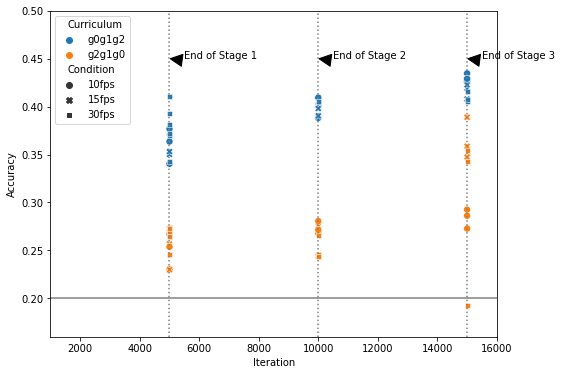

In [42]:
# df_all = deepcopy(df_fr)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_framerate.pdf', dpi=300)

## Number of Iterations

In [43]:
# Prepare a copy of df_def with the condition column added

dfdef_niter = deepcopy(df_def)
dfdef_niter['Condition'] = 'nep5'

In [44]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/num_ep/'

In [48]:
# # fix the filenames
# for stage in range(1,4):
#     emb_dir = emb_root+'s'+str(stage)+'/'
#     directory = emb_dir
#     for filename in os.listdir(directory):
#         if 'sgd' in filename:
#             new_filename = filename.replace('sgd', 'nep2')
#             old_path = os.path.join(directory, filename)
#             new_path = os.path.join(directory, new_filename)
#             os.rename(old_path, new_path)


In [ ]:
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
        
        if cond=='nep2':
            iter_per_stage = 2000 #@@
        elif cond=='nep5':
            iter_per_stage = 5000 #@@
        elif cond=='nep15':
            iter_per_stage = 15000 #@@
        
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_niter = pd.DataFrame.from_records(record_list)
df_niter = pd.concat((df_niter, dfdef_niter)) #add the default condition
df_niter

In [53]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['nep2','nep5','nep15']

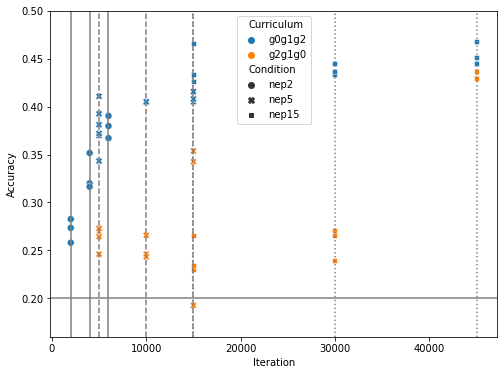

In [66]:
df_all = deepcopy(df_niter)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


ax.axvline(x=2000, color='gray', linestyle='solid')
ax.axvline(x=4000, color='gray', linestyle='solid')
ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dashed')
ax.axvline(x=10000, color='gray', linestyle='dashed')
ax.axvline(x=15000, color='gray', linestyle='dashed')

ax.axvline(x=15000, color='gray', linestyle='dotted')
ax.axvline(x=30000, color='gray', linestyle='dotted')
ax.axvline(x=45000, color='gray', linestyle='dotted')

# ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
#             arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
#             arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


plt.savefig('fig_sup_toybox_categorization_niter.pdf', dpi=300)

## Optimizer

In [67]:
# Prepare a copy of df_def with the condition column added

dfdef_optim = deepcopy(df_def)
dfdef_optim['Condition'] = 'sgd'

In [68]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/optim/'

In [69]:
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_optim = pd.DataFrame.from_records(record_list)
df_optim = pd.concat((df_optim, dfdef_optim)) #add the default condition
df_optim

100%|███████████████████████████████████████████| 18/18 [00:29<00:00,  1.66s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_223_adam,g2g1g0,adam,5000,0.094233
1,embeddings_g0_seed_233_adam,g0g1g2,adam,5000,0.338959
2,embeddings_g0_seed_221_adam,g0g1g2,adam,5000,0.109705
3,embeddings_g0_seed_231_adam,g0g1g2,adam,5000,0.284107
4,embeddings_g2_seed_223_adamw,g2g1g0,adamw,5000,0.412799
...,...,...,...,...,...
19,embeddings_g2_seed_212_sgd_pre.g0g1,g0g1g2,sgd,15000,0.405063
20,embeddings_g2_seed_213_sgd_pre.g0g1,g0g1g2,sgd,15000,0.407876
21,embeddings_g0_seed_213_sgd_pre.g2g1,g2g1g0,sgd,15000,0.353727
22,embeddings_g0_seed_211_sgd_pre.g2g1,g2g1g0,sgd,15000,0.192686


In [70]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['sgd','adam','adamw']

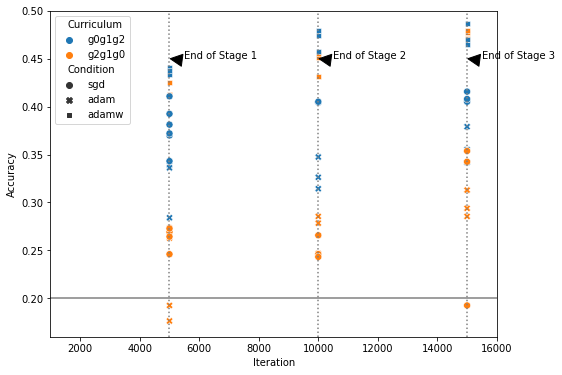

In [76]:
df_all = deepcopy(df_optim)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


plt.savefig('fig_sup_toybox_categorization_optim.pdf', dpi=300)

## Static Frame

In [24]:
# Prepare a copy of df_def with the condition column added

dfdef_static = deepcopy(df_def)
dfdef_static['Condition'] = 'video'

In [25]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/static_frame/'

In [15]:
ablation_cond = 'static'
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = ablation_cond#get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_static = pd.DataFrame.from_records(record_list)
df_static = pd.concat((df_static, dfdef_static)) #add the default condition
df_static

100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.96s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_413_static,g0g1g2,static,5000,0.238397
1,embeddings_g0_seed_223_static,g0g1g2,static,5000,0.281997
2,embeddings_g1_seed_413_static_pre.g0,g0g1g2,static,10000,0.338959
3,embeddings_g1_seed_223_static_pre.g0,g0g1g2,static,10000,0.331927
4,embeddings_g2_seed_223_static_pre.g0g1,g0g1g2,static,15000,0.379044
5,embeddings_g2_seed_413_static_pre.g0g1,g0g1g2,static,15000,0.393108
0,embeddings_g2_seed_212_sgd,g2,video,5000,0.248242
1,embeddings_g0_seed_662__sgd,g0,video,5000,0.401547
2,embeddings_g0_seed_213_sgd,g0,video,5000,0.345992
3,embeddings_g2_seed_211_sgd,g2,video,5000,0.263010


In [16]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['video','static']

Text(15500, 0.45, 'End of Stage 3')

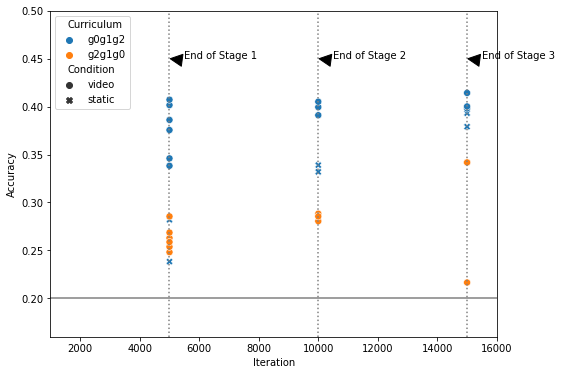

In [17]:
df_all = deepcopy(df_static)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

In [11]:
# Spatial transformation

dfdef_static_sp = deepcopy(df_defsp)
dfdef_static_sp['Condition'] = 'video'

In [12]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/static_frame/'

In [13]:
ablation_cond = 'static'
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = ablation_cond#get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_static_sp = pd.DataFrame.from_records(record_list)
df_static_sp = pd.concat((df_static_sp, dfdef_static_sp)) #add the default condition
df_static_sp

100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_413_static,g0g1g2,static,5000,0.425457
1,embeddings_g0_seed_223_static,g0g1g2,static,5000,0.434599
2,embeddings_g1_seed_413_static_pre.g0,g0g1g2,static,10000,0.490155
3,embeddings_g1_seed_223_static_pre.g0,g0g1g2,static,10000,0.491561
4,embeddings_g2_seed_223_static_pre.g0g1,g0g1g2,static,15000,0.511955
5,embeddings_g2_seed_413_static_pre.g0g1,g0g1g2,static,15000,0.521800
0,embeddings_g2_seed_212_sgd,g2,video,5000,0.414909
1,embeddings_g0_seed_662__sgd,g0,video,5000,0.511252
2,embeddings_g0_seed_213_sgd,g0,video,5000,0.477496
3,embeddings_g2_seed_211_sgd,g2,video,5000,0.428270


In [14]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['video','static']

Text(15500, 0.45, 'End of Stage 3')

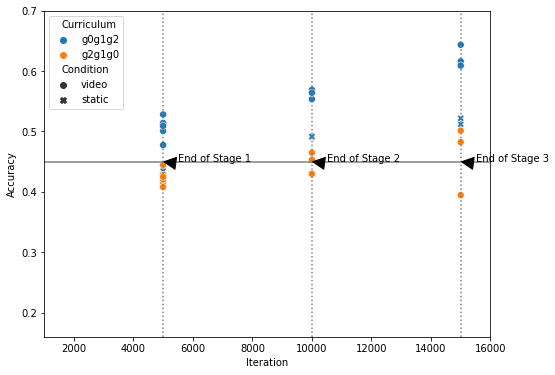

In [18]:
df_all = deepcopy(df_static_sp)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.45, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.7])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

## Shuffle

In [11]:
# Prepare a copy of df_def with the condition column added

dfdef_shuff = deepcopy(df_def)
dfdef_shuff['Condition'] = 'ordered'

In [12]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/shuffle/'

In [13]:
ablation_cond = 'shuffled'
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = ablation_cond#get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_shuff = pd.DataFrame.from_records(record_list)
df_shuff = pd.concat((df_shuff, dfdef_shuff)) #add the default condition
df_shuff

100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_363_shuffle,g0g1g2,shuffled,5000,0.322785
1,embeddings_g0_seed_361_shuffle,g0g1g2,shuffled,5000,0.339662
2,embeddings_g1_seed_363_shuffle_pre.g0,g0g1g2,shuffled,10000,0.387482
3,embeddings_g1_seed_361_shuffle_pre.g0,g0g1g2,shuffled,10000,0.405767
4,embeddings_g2_seed_363_shuffle_pre.g0g1,g0g1g2,shuffled,15000,0.421941
5,embeddings_g2_seed_361_shuffle_pre.g0g1,g0g1g2,shuffled,15000,0.416315
0,embeddings_g2_seed_212_sgd,g2,ordered,5000,0.269339
1,embeddings_g0_seed_662__sgd,g0,ordered,5000,0.389592
2,embeddings_g0_seed_213_sgd,g0,ordered,5000,0.362166
3,embeddings_g2_seed_211_sgd,g2,ordered,5000,0.225035


In [14]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['ordered','shuffled']

Text(15500, 0.45, 'End of Stage 3')

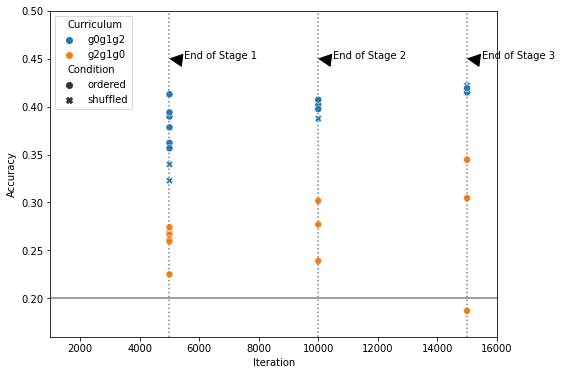

In [15]:
df_all = deepcopy(df_shuff)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

In [17]:
# Prepare a copy of df_def with the condition column added

dfdef_shuff_sp = deepcopy(df_defsp)
dfdef_shuff_sp['Condition'] = 'ordered'

In [18]:
ablation_cond = 'shuffled'
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = ablation_cond#get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_shuff_sp = pd.DataFrame.from_records(record_list)
df_shuff_sp = pd.concat((df_shuff_sp, dfdef_shuff_sp)) #add the default condition
df_shuff_sp

100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_363_shuffle,g0g1g2,shuffled,5000,0.489451
1,embeddings_g0_seed_361_shuffle,g0g1g2,shuffled,5000,0.488748
2,embeddings_g1_seed_363_shuffle_pre.g0,g0g1g2,shuffled,10000,0.525316
3,embeddings_g1_seed_361_shuffle_pre.g0,g0g1g2,shuffled,10000,0.535162
4,embeddings_g2_seed_363_shuffle_pre.g0g1,g0g1g2,shuffled,15000,0.565401
5,embeddings_g2_seed_361_shuffle_pre.g0g1,g0g1g2,shuffled,15000,0.594937
0,embeddings_g2_seed_212_sgd,g2,ordered,5000,0.405767
1,embeddings_g0_seed_662__sgd,g0,ordered,5000,0.518987
2,embeddings_g0_seed_213_sgd,g0,ordered,5000,0.455696
3,embeddings_g2_seed_211_sgd,g2,ordered,5000,0.434599


Text(15500, 0.65, 'End of Stage 3')

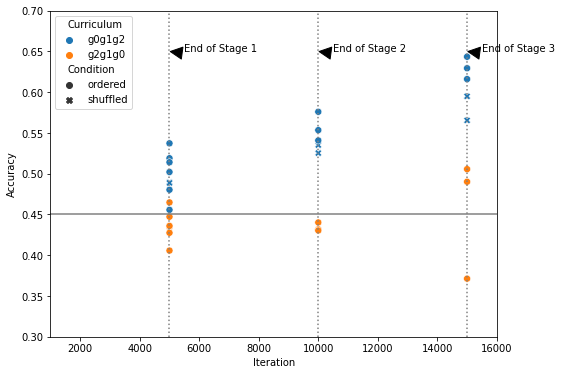

In [23]:
df_all = deepcopy(df_shuff_sp)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.45, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.3,0.7])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.65), xytext=(5500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.65), xytext=(10500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.65), xytext=(15500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

## Slowness
10fps. 
static vs shuffle vs normal (default)

In [12]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun15/'

In [14]:
iter_per_stage = 10000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
        print(Path(fp).stem)
        parts = Path(fp).stem.split('_')
        prefix, glast, _, seed, curr, *plast = parts
        tag = get_tag(fp)
        cond = plast[0]
        data_id = '_'.join([curr, seed, cond])
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_slowness = pd.DataFrame.from_records(record_list)
# df_slowness = pd.concat((df_optim, dfdef_optim)) #add the default condition
df_slowness

  0%|                                                     | 0/7 [00:00<?, ?it/s]

embeddings_g2_seed_152_adev_static


 14%|██████▍                                      | 1/7 [00:02<00:17,  2.85s/it]

embeddings_g2_seed_151_adev_static


 29%|████████████▊                                | 2/7 [00:05<00:12,  2.49s/it]

embeddings_g0_seed_152_dev_longshuffle


 43%|███████████████████▎                         | 3/7 [00:07<00:10,  2.58s/it]

embeddings_g2_seed_151_adev_default


 57%|█████████████████████████▋                   | 4/7 [00:10<00:07,  2.52s/it]

embeddings_g0_seed_151_dev_default


 71%|████████████████████████████████▏            | 5/7 [00:13<00:05,  2.78s/it]

embeddings_g2_seed_152_adev_default


 86%|██████████████████████████████████████▌      | 6/7 [00:16<00:02,  2.72s/it]

embeddings_g0_seed_151_dev_longshuffle


  0%|                                                     | 0/7 [00:00<?, ?it/s]

embeddings_g1_seed_151_adev_default_pre.g2


 14%|██████▍                                      | 1/7 [00:02<00:14,  2.47s/it]

embeddings_g1_seed_152_adev_default_pre.g2


 29%|████████████▊                                | 2/7 [00:05<00:12,  2.54s/it]

embeddings_g1_seed_151_adev_static_pre.g2


 43%|███████████████████▎                         | 3/7 [00:07<00:10,  2.52s/it]

embeddings_g1_seed_151_dev_default_pre.g0


 57%|█████████████████████████▋                   | 4/7 [00:10<00:07,  2.63s/it]

embeddings_g1_seed_151_dev_longshuffle_pre.g0


 71%|████████████████████████████████▏            | 5/7 [00:12<00:05,  2.61s/it]

embeddings_g1_seed_152_adev_static_pre.g2


 86%|██████████████████████████████████████▌      | 6/7 [00:15<00:02,  2.75s/it]

embeddings_g1_seed_152_dev_longshuffle_pre.g0


  0%|                                                     | 0/7 [00:00<?, ?it/s]

embeddings_g0_seed_152_adev_default_pre.g2g1


 14%|██████▍                                      | 1/7 [00:02<00:15,  2.54s/it]

embeddings_g0_seed_151_adev_default_pre.g2g1


 29%|████████████▊                                | 2/7 [00:05<00:14,  2.90s/it]

embeddings_g2_seed_152_dev_longshuffle_pre.g0g1


 43%|███████████████████▎                         | 3/7 [00:08<00:10,  2.69s/it]

embeddings_g0_seed_151_adev_static_pre.g2g1


 57%|█████████████████████████▋                   | 4/7 [00:10<00:07,  2.55s/it]

embeddings_g2_seed_151_dev_longshuffle_pre.g0g1


 71%|████████████████████████████████▏            | 5/7 [00:12<00:04,  2.45s/it]

embeddings_g2_seed_151_dev_default_pre.g0g1


 86%|██████████████████████████████████████▌      | 6/7 [00:15<00:02,  2.57s/it]

embeddings_g0_seed_152_adev_static_pre.g2g1


100%|█████████████████████████████████████████████| 7/7 [00:17<00:00,  2.55s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_152_adev_static,adev,static,10000,0.226442
1,embeddings_g2_seed_151_adev_static,adev,static,10000,0.265120
2,embeddings_g0_seed_152_dev_longshuffle,dev,longshuffle,10000,0.293952
3,embeddings_g2_seed_151_adev_default,adev,default,10000,0.272152
4,embeddings_g0_seed_151_dev_default,dev,default,10000,0.401547
5,embeddings_g2_seed_152_adev_default,adev,default,10000,0.251055
6,embeddings_g0_seed_151_dev_longshuffle,dev,longshuffle,10000,0.298875
7,embeddings_g1_seed_151_adev_default_pre.g2,adev,default,20000,0.275668
8,embeddings_g1_seed_152_adev_default_pre.g2,adev,default,20000,0.263010
9,embeddings_g1_seed_151_adev_static_pre.g2,adev,static,20000,0.260197


In [15]:
hue_order = ['dev',
            'adev']
style_order=['static','default', 'longshuffle']

Text(30500, 0.45, 'End of Stage 3')

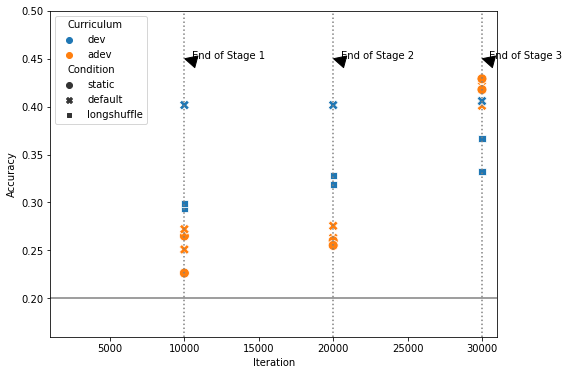

In [22]:
df_all = deepcopy(df_slowness)
df_all['Curriculum'] = df_all['Curriculum']#.map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=100,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')

ax.axvline(x=1*iter_per_stage, color='gray', linestyle='dotted')
ax.axvline(x=2*iter_per_stage, color='gray', linestyle='dotted')
ax.axvline(x=3*iter_per_stage, color='gray', linestyle='dotted')

ax.set_xlim([1000.,3*iter_per_stage+1000])
ax.set_ylim([0.16,0.5])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(iter_per_stage, 0.45), xytext=(iter_per_stage+500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(2*iter_per_stage, 0.45), xytext=(2*iter_per_stage+500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(3*iter_per_stage, 0.45), xytext=(3*iter_per_stage+500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

In [23]:
iter_per_stage = 10000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
        print(Path(fp).stem)
        parts = Path(fp).stem.split('_')
        prefix, glast, _, seed, curr, *plast = parts
        tag = get_tag(fp)
        cond = plast[0]
        data_id = '_'.join([curr, seed, cond])
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_slowness = pd.DataFrame.from_records(record_list)
# df_slowness = pd.concat((df_optim, dfdef_optim)) #add the default condition
df_slowness

  0%|                                                     | 0/7 [00:00<?, ?it/s]

embeddings_g2_seed_152_adev_static


 14%|██████▍                                      | 1/7 [00:02<00:12,  2.10s/it]

embeddings_g2_seed_151_adev_static


 29%|████████████▊                                | 2/7 [00:04<00:10,  2.04s/it]

embeddings_g0_seed_152_dev_longshuffle


 43%|███████████████████▎                         | 3/7 [00:05<00:07,  1.96s/it]

embeddings_g2_seed_151_adev_default


 57%|█████████████████████████▋                   | 4/7 [00:07<00:05,  1.85s/it]

embeddings_g0_seed_151_dev_default


 71%|████████████████████████████████▏            | 5/7 [00:10<00:04,  2.06s/it]

embeddings_g2_seed_152_adev_default


 86%|██████████████████████████████████████▌      | 6/7 [00:11<00:01,  1.98s/it]

embeddings_g0_seed_151_dev_longshuffle


  0%|                                                     | 0/7 [00:00<?, ?it/s]

embeddings_g1_seed_151_adev_default_pre.g2


 14%|██████▍                                      | 1/7 [00:01<00:11,  1.98s/it]

embeddings_g1_seed_152_adev_default_pre.g2


 29%|████████████▊                                | 2/7 [00:03<00:09,  1.83s/it]

embeddings_g1_seed_151_adev_static_pre.g2


 43%|███████████████████▎                         | 3/7 [00:05<00:07,  1.89s/it]

embeddings_g1_seed_151_dev_default_pre.g0


 57%|█████████████████████████▋                   | 4/7 [00:08<00:06,  2.24s/it]

embeddings_g1_seed_151_dev_longshuffle_pre.g0


 71%|████████████████████████████████▏            | 5/7 [00:10<00:04,  2.30s/it]

embeddings_g1_seed_152_adev_static_pre.g2


 86%|██████████████████████████████████████▌      | 6/7 [00:12<00:02,  2.06s/it]

embeddings_g1_seed_152_dev_longshuffle_pre.g0


  0%|                                                     | 0/7 [00:00<?, ?it/s]

embeddings_g0_seed_152_adev_default_pre.g2g1


 14%|██████▍                                      | 1/7 [00:02<00:16,  2.72s/it]

embeddings_g0_seed_151_adev_default_pre.g2g1


 29%|████████████▊                                | 2/7 [00:05<00:15,  3.02s/it]

embeddings_g2_seed_152_dev_longshuffle_pre.g0g1


 43%|███████████████████▎                         | 3/7 [00:08<00:11,  2.87s/it]

embeddings_g0_seed_151_adev_static_pre.g2g1


 57%|█████████████████████████▋                   | 4/7 [00:11<00:08,  2.68s/it]

embeddings_g2_seed_151_dev_longshuffle_pre.g0g1


 71%|████████████████████████████████▏            | 5/7 [00:13<00:05,  2.58s/it]

embeddings_g2_seed_151_dev_default_pre.g0g1


 86%|██████████████████████████████████████▌      | 6/7 [00:16<00:02,  2.68s/it]

embeddings_g0_seed_152_adev_static_pre.g2g1


100%|█████████████████████████████████████████████| 7/7 [00:18<00:00,  2.70s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_152_adev_static,adev,static,10000,0.405063
1,embeddings_g2_seed_151_adev_static,adev,static,10000,0.463432
2,embeddings_g0_seed_152_dev_longshuffle,dev,longshuffle,10000,0.515471
3,embeddings_g2_seed_151_adev_default,adev,default,10000,0.408579
4,embeddings_g0_seed_151_dev_default,dev,default,10000,0.536568
5,embeddings_g2_seed_152_adev_default,adev,default,10000,0.445148
6,embeddings_g0_seed_151_dev_longshuffle,dev,longshuffle,10000,0.490858
7,embeddings_g1_seed_151_adev_default_pre.g2,adev,default,20000,0.428973
8,embeddings_g1_seed_152_adev_default_pre.g2,adev,default,20000,0.422644
9,embeddings_g1_seed_151_adev_static_pre.g2,adev,static,20000,0.405063


Text(0.5, 1.0, 'toybox transformation classification')

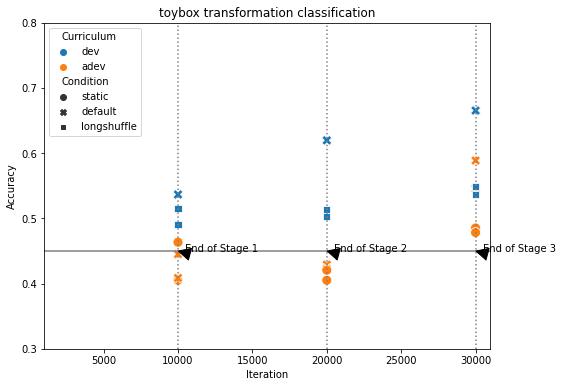

In [25]:
df_all = deepcopy(df_slowness)
df_all['Curriculum'] = df_all['Curriculum']#.map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=100,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.45, color='gray', linestyle='solid')

ax.axvline(x=1*iter_per_stage, color='gray', linestyle='dotted')
ax.axvline(x=2*iter_per_stage, color='gray', linestyle='dotted')
ax.axvline(x=3*iter_per_stage, color='gray', linestyle='dotted')

ax.set_xlim([1000.,3*iter_per_stage+1000])
ax.set_ylim([0.3,0.8])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(iter_per_stage, 0.45), xytext=(iter_per_stage+500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(2*iter_per_stage, 0.45), xytext=(2*iter_per_stage+500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(3*iter_per_stage, 0.45), xytext=(3*iter_per_stage+500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.set_title('toybox transformation classification')
# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

Text(15500, 0.65, 'End of Stage 3')

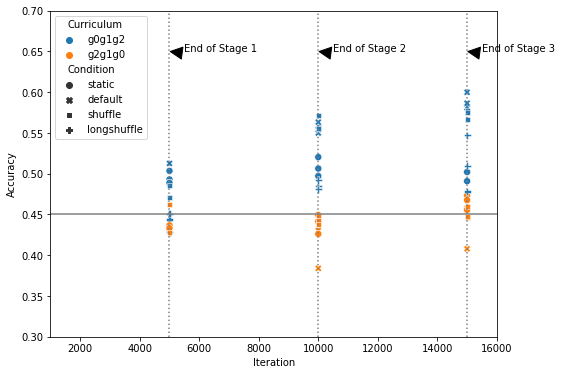

In [15]:
df_all = deepcopy(df_slowness_sp)
df_all['Curriculum'] = df_all['Curriculum']#.map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.45, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.3,0.7])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.65), xytext=(5500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.65), xytext=(10500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.65), xytext=(15500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

In [16]:
def get_separability_score(df, label, method='sgd', ret_preds=False):
    # method: sgd or svm
#     le = preprocessing.LabelEncoder()
    y = df[label] #le.fit_transform(df[label])
    
    X_cols = ['dim'+str(i)
              for i in range(768)]
    X = df[X_cols]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    if method=='svm':
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(random_state=0, tol=1e-4))
    elif method=='sgd':
        clf = make_pipeline(StandardScaler(),
                            SGDClassifier(max_iter=1000, tol=1e-4, n_jobs=60))#, loss='log_loss'))
    else:
        raise ValueError()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    if ret_preds:
        preds = clf.predict(X_test)
        return train_score, test_score, preds, y_test
    return train_score, test_score

In [17]:
def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[2]
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        full_tag = glast
    return full_tag

def get_ablation_cond(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
#     other_id = parts[5]
    cond = parts[7]
    return cond

def proc_fp(fp):
    df = pd.read_csv(fp)
    
    method='sgd'
    train_score, test_score = get_separability_score(df, 'labels', method=method, ret_preds=False)
    return test_score

In [18]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/ucf101/ablations/slowness/'

In [25]:
# # temp: when we want to add the longshuffle condition, but not recompute everything
# record_list = []
# iter_per_stage = 5000
# for stage in range(1,4):
#     emb_dir = emb_root+'s'+str(stage)+'/'
#     fpathlist = [emb_dir+fname
#                 for fname in os.listdir(emb_dir)
#                 if Path(emb_dir+fname).suffix=='.csv']
#     for i, fp in enumerate(tqdm(fpathlist)):
#         if Path(fp).stem.split('_')[1]=='na':
#             continue
#         tag = get_tag(fp)
#         curr = tagname_dict[tag]
#         cond = get_ablation_cond(fp)
        
#         if cond!='longshuffle':
#             continue
        
#         tag = tag.replace('g3','ga')
#         score = proc_fp(fp)
#         record = {'fname': Path(fp).stem,
#                   'tag': tag,
#                   'Curriculum': curr,
#                   'Condition': cond,
#                  'Iteration': iter_per_stage*stage,
#                   'Accuracy': score}
#         record_list.append(deepcopy(record))
        
# xdf_longshuffle = pd.DataFrame.from_records(record_list)
# df_slowness_ucf = pd.concat((df_slowness_ucf, xdf_longshuffle)) 

In [15]:
record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
        if Path(fp).stem.split('_')[1]=='na':
            continue
        tag = get_tag(fp)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
        
        if (curr=='Youngest Only') | (curr=='Oldest Only'):
            continue
        tag = tag.replace('g3','ga')
        score = proc_fp(fp)
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

  0%|                                                    | 0/16 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
  6%|██▊                                         | 1/16 [01:20<20:04, 80.33s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 12%|█████▌                                      | 2/16 [02:45<19:28, 83.45s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to impro

 53%|███████████████████████▍                    | 8/15 [08:59<08:16, 70.88s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 60%|██████████████████████████▍                 | 9/15 [09:36<06:01, 60.19s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 67%|████████████████████████████▋              | 10/15 [10:14<04:27, 53.41s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to impro

In [ ]:
df_slowness_ucf= pd.DataFrame.from_records(record_list)
# df_slowness = pd.concat((df_optim, dfdef_optim)) #add the default condition
df_slowness_ucf

In [ ]:
# df_slowness_ucf.to_csv('df_slowness_ucf.csv', index=False)
# df_slowness_ucf = pd.read_csv('df_slowness_ucf.csv')
df_slowness_ucf

In [19]:
# for index, row in df_slowness_ucf.iterrows():
#     cond = row['fname'].split('_')[7]
# #     print(cond)
#     df_slowness_ucf.at[index, 'Condition'] = cond

In [28]:
df_slowness_ucf

,fname,tag,Curriculum,Condition,Iteration,Accuracy
0,embeddings_model_g0_seed_683_other_683_shuffle,g0,g0g1g2,shuffle,5000,0.176029
1,embeddings_model_g2_seed_683_other_683_default,g2,g2g1g0,default,5000,0.156698
2,embeddings_model_g0_seed_681_other_681_shuffle,g0,g0g1g2,shuffle,5000,0.177621
3,embeddings_model_g2_seed_681_other_681_shuffle,g2,g2g1g0,shuffle,5000,0.165113
4,embeddings_model_g2_seed_681_other_681_static,g2,g2g1g0,static,5000,0.164658
5,embeddings_model_g2_seed_683_other_683_static,g2,g2g1g0,static,5000,0.153059
6,embeddings_model_g0_seed_683_other_683_default,g0,g0g1g2,default,5000,0.244712
7,embeddings_model_g0_seed_681_other_681_default,g0,g0g1g2,default,5000,0.258131
8,embeddings_model_g2_seed_682_other_682_shuffle,g2,g2g1g0,shuffle,5000,0.155788
9,embeddings_model_g2_seed_683_other_683_shuffle,g2,g2g1g0,shuffle,5000,0.152604


In [29]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['static','default','shuffle', 'longshuffle']

Text(15500, 0.45, 'End of Stage 3')

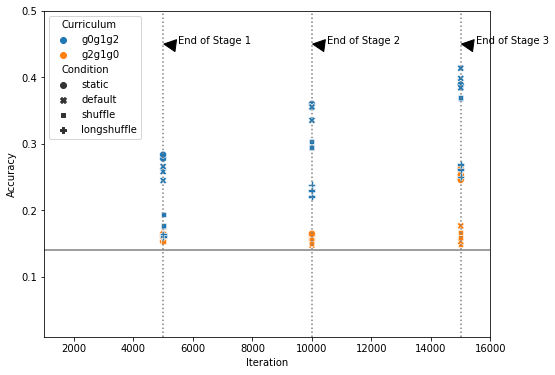

In [30]:
cdata=deepcopy(df_slowness_ucf)

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, linewidth=0.5,
#             hue_order=hue_order)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
ax.axhline(y=0.14, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.01,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_ucf.pdf', dpi=300)

## Mask Sampler

In [9]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/masksampler/'

In [10]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_ms = pd.DataFrame.from_records(record_list)
df_ms

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_581_random,g0g1g2,random,5000,0.359353
1,embeddings_g1_seed_581_random_pre.g0,g0g1g2,random,10000,0.362166
2,embeddings_g2_seed_581_random_pre.g0g1,g0g1g2,random,15000,0.409986


In [11]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_mssp = pd.DataFrame.from_records(record_list)
df_mssp

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_581_random,g0g1g2,random,5000,0.522504
1,embeddings_g1_seed_581_random_pre.g0,g0g1g2,random,10000,0.618143
2,embeddings_g2_seed_581_random_pre.g0g1,g0g1g2,random,15000,0.635724


### Temp: Jun8

In [9]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun8/'

In [16]:
tagname_dict = {
    'g0':'any', 
    'g0g1': 'g0g1g2', 
    'g0g1g2': 'g0g1g2',
    'g2':'any', 
    'g2g1': 'g2g1g0', 
    'g2g1g0': 'g2g1g0',
    'g2g2': 'g2g2g2',
    'g2g2g2':'g2g2g2',
    'g0g0': 'g0g0g0', 
    'g0g0g0':'g0g0g0'}

In [14]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.42s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_821_sgd,any,sgd,5000,0.379044
1,embeddings_g0_seed_821_sgd,any,sgd,5000,0.225738
2,embeddings_g0_seed_821_sgd_pre.g0,g0g0g0,sgd,10000,0.341772
3,embeddings_g1_seed_821_sgd_pre.g0,g0g1g2,sgd,10000,0.363572
4,embeddings_g2_seed_821_sgd_pre.g2,g2g2g2,sgd,10000,0.428973
5,embeddings_g2_seed_821_sgd_pre.g0g1,g0g1g2,sgd,15000,0.407876
6,embeddings_g2_seed_821_sgd_pre.g2g2,g2g2g2,sgd,15000,0.438819
7,embeddings_g0_seed_821_sgd_pre.g0g0,g0g0g0,sgd,15000,0.446554


In [15]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

100%|█████████████████████████████████████████████| 3/3 [00:07<00:00,  2.37s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_821_sgd,any,sgd,5000,0.490858
1,embeddings_g0_seed_821_sgd,any,sgd,5000,0.431083
2,embeddings_g0_seed_821_sgd_pre.g0,g0g0g0,sgd,10000,0.437412
3,embeddings_g1_seed_821_sgd_pre.g0,g0g1g2,sgd,10000,0.511955
4,embeddings_g2_seed_821_sgd_pre.g2,g2g2g2,sgd,10000,0.623066
5,embeddings_g2_seed_821_sgd_pre.g0g1,g0g1g2,sgd,15000,0.627286
6,embeddings_g2_seed_821_sgd_pre.g2g2,g2g2g2,sgd,15000,0.665260
7,embeddings_g0_seed_821_sgd_pre.g0g0,g0g0g0,sgd,15000,0.592124


In [16]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/ucf101/jun8/'

In [ ]:
def proc_fp(fp):
    df = pd.read_csv(fp)
    
    method='sgd'
    train_score, test_score = get_separability_score(df, 'labels', method=method, ret_preds=False)
    return test_score

In [19]:
record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
        if Path(fp).stem.split('_')[1]=='na':
            continue
        tag = get_tag(fp)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
        
#         if (curr=='Youngest Only') | (curr=='Oldest Only'):
#             continue
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp)
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

  0%|                                                     | 0/2 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 50%|██████████████████████                      | 1/2 [01:59<01:59, 119.12s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
  0%|                                                     | 0/3 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to impro

In [20]:
df_ucf = pd.DataFrame.from_records(record_list)

In [21]:
df_ucf

,fname,tag,Curriculum,Iteration,Accuracy
0,embeddings_model_g0_seed_821_other_821_sgd,g0,any,5000,0.139413
1,embeddings_model_g2_seed_821_other_821_sgd,g2,any,5000,0.274733
2,embeddings_model_g1_seed_821_other_821_sgd_pre.g0,g0g1,g0g1g2,10000,0.293837
3,embeddings_model_g2_seed_821_other_821_sgd_pre.g2,g2g2,g2g2g2,10000,0.392995
4,embeddings_model_g0_seed_821_other_821_sgd_pre.g0,g0g0,g0g0g0,10000,0.206732
5,embeddings_model_g2_seed_821_other_821_sgd_pre...,g0g1g2,g0g1g2,15000,0.418012
6,embeddings_model_g2_seed_821_other_821_sgd_pre...,g2g2g2,g2g2g2,15000,0.469184
7,embeddings_model_g0_seed_821_other_821_sgd_pre...,g0g0g0,g0g0g0,15000,0.448942


## Temp: Jun9

In [18]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun9/'

In [19]:
def get_seed(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
    return parts[3]

def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[1]
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        full_tag = glast
        
    return full_tag

tagname_dict = {
    'g0':'g0 any', 
    'g0g1': 'g0g1g2', 
    'g0g1g2': 'g0g1g2',
    'g2':'g2 any', 
    'g2g1': 'g2g1g0', 
    'g2g1g0': 'g2g1g0',
    'g2g2': 'g2g2g2',
    'g2g2g2':'g2g2g2',
    'g0g0': 'g0g0g0', 
    'g0g0g0':'g0g0g0'}

In [21]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

  0%|                                                    | 0/13 [00:00<?, ?it/s]

embeddings_g2_seed_921_antidev


  8%|███▍                                        | 1/13 [00:01<00:19,  1.65s/it]

embeddings_g2_seed_922_antidev


 15%|██████▊                                     | 2/13 [00:03<00:18,  1.69s/it]

embeddings_g0_seed_921_yo


 23%|██████████▏                                 | 3/13 [00:04<00:16,  1.63s/it]

embeddings_g0_seed_926_dev


 31%|█████████████▌                              | 4/13 [00:06<00:14,  1.62s/it]

embeddings_g0_seed_923_dev


 38%|████████████████▉                           | 5/13 [00:08<00:12,  1.60s/it]

embeddings_g2_seed_921_oo


 46%|████████████████████▎                       | 6/13 [00:09<00:11,  1.64s/it]

embeddings_g2_seed_922_oo


 54%|███████████████████████▋                    | 7/13 [00:11<00:10,  1.69s/it]

embeddings_g0_seed_923_yo


 62%|███████████████████████████                 | 8/13 [00:13<00:08,  1.73s/it]

embeddings_g2_seed_923_oo


 69%|██████████████████████████████▍             | 9/13 [00:14<00:06,  1.62s/it]

embeddings_g0_seed_922_dev


 77%|█████████████████████████████████          | 10/13 [00:16<00:04,  1.66s/it]

embeddings_g0_seed_921_dev


 85%|████████████████████████████████████▍      | 11/13 [00:18<00:03,  1.60s/it]

embeddings_g0_seed_926_yo


 92%|███████████████████████████████████████▋   | 12/13 [00:19<00:01,  1.55s/it]

embeddings_g0_seed_922_yo


  0%|                                                    | 0/13 [00:00<?, ?it/s]

embeddings_g1_seed_922_dev_pre.g0


  8%|███▍                                        | 1/13 [00:01<00:20,  1.68s/it]

embeddings_g0_seed_921_yo_pre.g0


 15%|██████▊                                     | 2/13 [00:03<00:17,  1.63s/it]

embeddings_g0_seed_922_yo_pre.g0


 23%|██████████▏                                 | 3/13 [00:05<00:16,  1.67s/it]

embeddings_g2_seed_923_oo_pre.g2


 31%|█████████████▌                              | 4/13 [00:06<00:15,  1.73s/it]

embeddings_g1_seed_923_dev_pre.g0


 38%|████████████████▉                           | 5/13 [00:08<00:13,  1.69s/it]

embeddings_g2_seed_921_oo_pre.g2


 46%|████████████████████▎                       | 6/13 [00:10<00:11,  1.66s/it]

embeddings_g1_seed_926_dev_pre.g0


 54%|███████████████████████▋                    | 7/13 [00:11<00:09,  1.64s/it]

embeddings_g2_seed_922_oo_pre.g2


 62%|███████████████████████████                 | 8/13 [00:13<00:08,  1.74s/it]

embeddings_g0_seed_923_yo_pre.g0


 69%|██████████████████████████████▍             | 9/13 [00:15<00:07,  1.79s/it]

embeddings_g0_seed_926_yo_pre.g0


 77%|█████████████████████████████████          | 10/13 [00:16<00:05,  1.70s/it]

embeddings_g1_seed_921_dev_pre.g0


 85%|████████████████████████████████████▍      | 11/13 [00:19<00:03,  1.95s/it]

embeddings_g1_seed_922_antidev_pre.g2


 92%|███████████████████████████████████████▋   | 12/13 [00:21<00:01,  1.85s/it]

embeddings_g1_seed_921_antidev_pre.g2


  0%|                                                    | 0/12 [00:00<?, ?it/s]

embeddings_g0_seed_922_yo_pre.g0g0


  8%|███▋                                        | 1/12 [00:01<00:19,  1.73s/it]

embeddings_g2_seed_923_dev_pre.g0g1


 17%|███████▎                                    | 2/12 [00:03<00:17,  1.78s/it]

embeddings_g2_seed_921_dev_pre.g0g1


 25%|███████████                                 | 3/12 [00:05<00:15,  1.68s/it]

embeddings_g2_seed_922_dev_pre.g0g1


 33%|██████████████▋                             | 4/12 [00:07<00:14,  1.81s/it]

embeddings_g2_seed_921_oo_pre.g2g2


 42%|██████████████████▎                         | 5/12 [00:08<00:11,  1.66s/it]

embeddings_g2_seed_923_oo_pre.g2g2


 50%|██████████████████████                      | 6/12 [00:10<00:10,  1.68s/it]

embeddings_g2_seed_922_oo_pre.g2g2


 58%|█████████████████████████▋                  | 7/12 [00:11<00:08,  1.62s/it]

embeddings_g2_seed_926_dev_pre.g0g1


 67%|█████████████████████████████▎              | 8/12 [00:13<00:06,  1.61s/it]

embeddings_g0_seed_922_antidev_pre.g2g1


 75%|█████████████████████████████████           | 9/12 [00:15<00:05,  1.67s/it]

embeddings_g0_seed_921_antidev_pre.g2g1


 83%|███████████████████████████████████▊       | 10/12 [00:16<00:03,  1.71s/it]

embeddings_g0_seed_921_yo_pre.g0g0


 92%|███████████████████████████████████████▍   | 11/12 [00:18<00:01,  1.69s/it]

embeddings_g0_seed_926_yo_pre.g0g0


100%|███████████████████████████████████████████| 12/12 [00:20<00:00,  1.68s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_921_antidev,g2 any,antidev,5000,0.254571
1,embeddings_g2_seed_922_antidev,g2 any,antidev,5000,0.277075
2,embeddings_g0_seed_921_yo,g0 any,yo,5000,0.395921
3,embeddings_g0_seed_926_dev,g0 any,dev,5000,0.422644
4,embeddings_g0_seed_923_dev,g0 any,dev,5000,0.398031
5,embeddings_g2_seed_921_oo,g2 any,oo,5000,0.264416
6,embeddings_g2_seed_922_oo,g2 any,oo,5000,0.244023
7,embeddings_g0_seed_923_yo,g0 any,yo,5000,0.430380
8,embeddings_g2_seed_923_oo,g2 any,oo,5000,0.255977
9,embeddings_g0_seed_922_dev,g0 any,dev,5000,0.408579


In [22]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

100%|███████████████████████████████████████████| 12/12 [00:21<00:00,  1.81s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_921_antidev,g2 any,antidev,5000,0.424051
1,embeddings_g2_seed_922_antidev,g2 any,antidev,5000,0.414909
2,embeddings_g0_seed_921_yo,g0 any,yo,5000,0.577356
3,embeddings_g0_seed_926_dev,g0 any,dev,5000,0.575949
4,embeddings_g0_seed_923_dev,g0 any,dev,5000,0.616737
5,embeddings_g2_seed_921_oo,g2 any,oo,5000,0.456399
6,embeddings_g2_seed_922_oo,g2 any,oo,5000,0.447961
7,embeddings_g0_seed_923_yo,g0 any,yo,5000,0.565401
8,embeddings_g2_seed_923_oo,g2 any,oo,5000,0.407173
9,embeddings_g0_seed_922_dev,g0 any,dev,5000,0.580872


## Temp: Jun10

In [9]:
tagname_dict = {
    'g0':'g0 any', 
    'g0g1': 'g0g1g2', 
    'g0g1g2': 'g0g1g2',
    'g2':'g2 any', 
    'g2g1': 'g2g1g0', 
    'g2g1g0': 'g2g1g0',
    'g2g2': 'g2g2g2',
    'g2g2g2':'g2g2g2',
    'g0g0': 'g0g0g0', 
    'g0g0g0':'g0g0g0'}

In [23]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun10/'

In [24]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.80s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_927_dev,g0 any,dev,5000,0.402250
1,embeddings_g0_seed_927_yo,g0 any,yo,5000,0.406470
2,embeddings_g0_seed_923_yo,g0 any,yo,5000,0.409283
3,embeddings_g2_seed_927_oo,g2 any,oo,5000,0.263010
4,embeddings_g0_seed_923_yo_pre.g0,g0g0g0,yo,10000,0.426160
5,embeddings_g2_seed_927_oo_pre.g2,g2g2g2,oo,10000,0.247539
6,embeddings_g1_seed_927_dev_pre.g0,g0g1g2,dev,10000,0.407876
7,embeddings_g0_seed_927_yo_pre.g0,g0g0g0,yo,10000,0.428270
8,embeddings_g0_seed_923_yo_pre.g0g0,g0g0g0,yo,15000,0.442335
9,embeddings_g2_seed_927_dev_pre.g0g1,g0g1g2,dev,15000,0.444444


In [25]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.43s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_927_dev,g0 any,dev,5000,0.613924
1,embeddings_g0_seed_927_yo,g0 any,yo,5000,0.601969
2,embeddings_g0_seed_923_yo,g0 any,yo,5000,0.620253
3,embeddings_g2_seed_927_oo,g2 any,oo,5000,0.450774
4,embeddings_g0_seed_923_yo_pre.g0,g0g0g0,yo,10000,0.635724
5,embeddings_g2_seed_927_oo_pre.g2,g2g2g2,oo,10000,0.433896
6,embeddings_g1_seed_927_dev_pre.g0,g0g1g2,dev,10000,0.650492
7,embeddings_g0_seed_927_yo_pre.g0,g0g0g0,yo,10000,0.654008
8,embeddings_g0_seed_923_yo_pre.g0g0,g0g0g0,yo,15000,0.668073
9,embeddings_g2_seed_927_dev_pre.g0g1,g0g1g2,dev,15000,0.692686


In [9]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/ucf101/jun10/'

In [12]:
def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[2]
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        full_tag = glast
    return full_tag

def get_ablation_cond(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
#     other_id = parts[5]
    cond = parts[7]
    return cond

def proc_fp(fp):
    df = pd.read_csv(fp)
    
    method='sgd'
    train_score, test_score = get_separability_score(df, 'labels', method=method, ret_preds=False)
    return test_score

In [19]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(3,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
        print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
        print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp)
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

  0%|                                                     | 0/4 [00:00<?, ?it/s]

embeddings_model_g2_seed_927_other_927_dev_pre.g0g1
dev


 25%|███████████▎                                 | 1/4 [00:28<01:25, 28.63s/it]

embeddings_model_g0_seed_923_other_923_yo_pre.g0g0
yo


/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 50%|██████████████████████▌                      | 2/4 [01:04<01:05, 32.81s/it]

embeddings_model_g0_seed_927_other_927_yo_pre.g0g0
yo


/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 75%|█████████████████████████████████▊           | 3/4 [01:36<00:32, 32.57s/it]

embeddings_model_g2_seed_927_other_927_oo_pre.g2g2
oo


/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
100%|█████████████████████████████████████████████| 4/4 [03:09<00:00, 47.38s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_model_g2_seed_927_other_927_dev_pre...,g0g1g2,dev,15000,0.443029
1,embeddings_model_g0_seed_923_other_923_yo_pre....,g0g0g0,yo,15000,0.459859
2,embeddings_model_g0_seed_927_other_927_yo_pre....,g0g0g0,yo,15000,0.478053
3,embeddings_model_g2_seed_927_other_927_oo_pre....,g2g2g2,oo,15000,0.136002


## June 11
Long training. only compare 012, 000. 2 seeds

In [10]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun11/'

In [11]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.85s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_142_yo,g0 any,yo,5000,0.443038
1,embeddings_g0_seed_141_yo,g0 any,yo,5000,0.457103
2,embeddings_g0_seed_142_dev,g0 any,dev,5000,0.447961
3,embeddings_g0_seed_141_dev,g0 any,dev,5000,0.443038
4,embeddings_g0_seed_142_yo_pre.g0,g0g0g0,yo,10000,0.433896
5,embeddings_g1_seed_142_dev_pre.g0,g0g1g2,dev,10000,0.430380
6,embeddings_g1_seed_141_dev_pre.g0,g0g1g2,dev,10000,0.462025
7,embeddings_g0_seed_141_yo_pre.g0,g0g0g0,yo,10000,0.469058
8,embeddings_g0_seed_142_yo_pre.g0g0,g0g0g0,yo,15000,0.439522
9,embeddings_g2_seed_141_dev_pre.g0g1,g0g1g2,dev,15000,0.459212


In [12]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_142_yo,g0 any,yo,5000,0.696906
1,embeddings_g0_seed_141_yo,g0 any,yo,5000,0.710267
2,embeddings_g0_seed_142_dev,g0 any,dev,5000,0.689170
3,embeddings_g0_seed_141_dev,g0 any,dev,5000,0.699719
4,embeddings_g0_seed_142_yo_pre.g0,g0g0g0,yo,10000,0.741210
5,embeddings_g1_seed_142_dev_pre.g0,g0g1g2,dev,10000,0.748242
6,embeddings_g1_seed_141_dev_pre.g0,g0g1g2,dev,10000,0.767932
7,embeddings_g0_seed_141_yo_pre.g0,g0g0g0,yo,10000,0.746132
8,embeddings_g0_seed_142_yo_pre.g0g0,g0g0g0,yo,15000,0.777075
9,embeddings_g2_seed_141_dev_pre.g0g1,g0g1g2,dev,15000,0.789733


In [13]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/ucf101/jun11/'

def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[2]
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        full_tag = glast
    return full_tag

def get_ablation_cond(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
#     other_id = parts[5]
    cond = parts[7]
    return cond

def proc_fp(fp):
    df = pd.read_csv(fp)
    
    method='sgd'
    train_score, test_score = get_separability_score(df, 'labels', method=method, ret_preds=False)
    return test_score


record_list = []
iter_per_stage = 5000 #@@
for stage in range(3,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
        print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
        print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp)
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

  0%|                                                     | 0/4 [00:00<?, ?it/s]

embeddings_model_g0_seed_142_other_142_yo_pre.g0g0
yo


 25%|███████████▎                                 | 1/4 [00:26<01:19, 26.64s/it]

embeddings_model_g2_seed_141_other_141_dev_pre.g0g1
dev


 50%|██████████████████████▌                      | 2/4 [00:46<00:45, 22.91s/it]

embeddings_model_g2_seed_142_other_142_dev_pre.g0g1
dev


 75%|█████████████████████████████████▊           | 3/4 [01:16<00:25, 25.76s/it]

embeddings_model_g0_seed_141_other_141_yo_pre.g0g0
yo


100%|█████████████████████████████████████████████| 4/4 [01:39<00:00, 24.78s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_model_g0_seed_142_other_142_yo_pre....,g0g0g0,yo,15000,0.511940
1,embeddings_model_g2_seed_141_other_141_dev_pre...,g0g1g2,dev,15000,0.539459
2,embeddings_model_g2_seed_142_other_142_dev_pre...,g0g1g2,dev,15000,0.479645
3,embeddings_model_g0_seed_141_other_141_yo_pre....,g0g0g0,yo,15000,0.569024


### June 12

In [9]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun12/'

In [12]:
record_list = []
iter_per_stage = 10000 #@@
for stage in range(1,2):#4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_143_oo,g2g1g0,oo,10000,0.379747
1,embeddings_g0_seed_141_yo,g0g1g2,yo,10000,0.273558


In [13]:
record_list = []
iter_per_stage = 10000 #@@
for stage in range(1,2):#4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_143_oo,g2g1g0,oo,10000,0.650492
1,embeddings_g0_seed_141_yo,g0g1g2,yo,10000,0.449367


## June 21

In [10]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun21/'

In [11]:
record_list = []
iter_per_stage = 10000 #@@
for stage in range(1,2):#4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.73s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_212_adev_default,g2g1g0,adev,10000,0.377667
1,embeddings_g2_seed_211_adev_default,g2g1g0,adev,10000,0.338790
2,embeddings_g0_seed_212_dev_default,g0g1g2,dev,10000,0.402032
3,embeddings_g0_seed_211_dev_default,g0g1g2,dev,10000,0.411160


In [12]:
record_list = []
iter_per_stage = 10000 #@@
for stage in range(1,2):#4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         if ('gr' in tag) |\
#         ('g3' in tag) |\
#         ('g0g0' in tag) |\
#         ('g2g2' in tag):
#                 continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         print(cond)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df = pd.DataFrame.from_records(record_list)
df

100%|█████████████████████████████████████████████| 4/4 [00:12<00:00,  3.12s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_212_adev_default,g2g1g0,adev,10000,0.367710
1,embeddings_g2_seed_211_adev_default,g2g1g0,adev,10000,0.395018
2,embeddings_g0_seed_212_dev_default,g0g1g2,dev,10000,0.363570
3,embeddings_g0_seed_211_dev_default,g0g1g2,dev,10000,0.346549


## June 21,26,27

In [12]:
def parse_fname(fp):
#     train_val_scores_g0_seed_262_dev_notime.csv
# train_val_scores_g0_seed_262_adev_notime_pre.g2g1.csv
# gradmean_g2_seed_262_adev_notime.json
# gradsnr_g1_seed_261_adev_notime_pre.g2.json
    parts = Path(fp).stem.split('_')
    if parts[0]=='train':
        _,_,_,current_gr, _,seed, curr, *other = parts
    elif parts[0][:4]=='grad':
        prefix, current_gr, _, seed, curr, *other = parts
    elif parts[0]=='embeddings':
        prefix, current_gr, _, seed, curr, *other = parts
    
    cond = other[0]
    previous_gr = ''
    if len(other)>1:
        previous_gr += other[1].replace('pre.', '')
    train_gr = previous_gr+current_gr
    
    tag_dict = {
        'Curriculum':curr,
        'Condition':cond,
        'Seed': seed,
        'Train Groups': train_gr,
        'data_id': '_'.join([curr, seed, cond])
    }
    return tag_dict

In [16]:
def proc_fp_model(fp, stage, num_ep, iter_per_ep):
    df = pd.read_csv(fp).iloc[:,1:]
    df = edit_epoch(df, stage, iter_per_ep, num_ep)
    tag_dict = parse_fname(fp)
    for tag in tag_dict.keys():
        df[tag] = tag_dict[tag]
    df = df.rename(columns={
    'epoch': 'Epoch',
    'iteration': 'Iteration',
    'train_loss': 'Train Loss',
    'val_loss': 'Validation Loss'
    })
    df['Train Loss Reduction'] = df['Train Loss'].diff(periods=-1)
    df['Validation Loss Reduction'] = df['Validation Loss'].diff(periods=-1)
    return df

def proc_result_folder(root, ds_task, iter_per_stage):
    record_list = []
    folders = sorted(list(os.listdir(root)))
    for stage in range(1,4):
        stage_str = 's'+str(stage)
        if stage_str in folders:
            emb_dir = str(Path(root, stage_str))
            fpathlist = [str(Path(emb_dir,fname))
                         for fname in os.listdir(emb_dir)
                         if Path(emb_dir,fname).suffix=='.csv']
            for fp in tqdm(fpathlist):
                tag_dict = parse_fname(fp)
                score = proc_fp(fp, ds_task)
                
                record = {'fname': Path(fp).stem,
                  'Curriculum': tag_dict['Curriculum'],
                  'Condition': tag_dict['Condition'],
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
                record_list.append(deepcopy(record))
    df = pd.DataFrame.from_records(record_list)         
    return df

In [17]:
# record_list = []
# iter_per_stage = 10000 #@@
# for stage in range(1,2):#4):
#     emb_dir = emb_root+'s'+str(stage)+'/'
#     fpathlist = [emb_dir+fname
#                 for fname in os.listdir(emb_dir)
#                 if Path(emb_dir+fname).suffix=='.csv']
#     for i, fp in enumerate(tqdm(fpathlist)):
# #         print(Path(fp).stem)
#         tag = get_tag(fp)
# #         if ('gr' in tag) |\
# #         ('g3' in tag) |\
# #         ('g0g0' in tag) |\
# #         ('g2g2' in tag):
# #                 continue # skip other curricula
# #         print(tag)
#         curr = tagname_dict[tag]
#         cond = get_ablation_cond(fp)
# #         print(cond)
# #         tag = tag.replace('g3','ga')
#         score = proc_fp(fp, 'category')
#         record = {'fname': Path(fp).stem,
#                   'Curriculum': curr,
#                   'Condition': cond,
#                  'Iteration': iter_per_stage*stage,
#                   'Accuracy': score}
#         record_list.append(deepcopy(record))
# df = pd.DataFrame.from_records(record_list)
# df

In [71]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun21/'
ds_task = 'category'
num_ep,iter_per_ep = 5, 2000
iter_per_stage = num_ep*iter_per_ep
df21 = proc_result_folder(emb_root, ds_task, iter_per_stage)
df21['Condition'] = df21['Condition'].map({'default':'time matched'})

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


In [72]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun26/'
ds_task = 'category'
num_ep,iter_per_ep = 5, 2000
iter_per_stage = num_ep*iter_per_ep
df26 = proc_result_folder(emb_root, ds_task, iter_per_stage)

100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.60s/it]


In [73]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun27/'
ds_task = 'category'
num_ep,iter_per_ep = 5, 2000
iter_per_stage = num_ep*iter_per_ep
df27 = proc_result_folder(emb_root, ds_task, iter_per_stage)

100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.52s/it]


In [74]:
condition_mapdict={'default':'space matched',
                  'notime':'space & time matched'}
df26['Condition'] = df26['Condition'].map(condition_mapdict)
df27['Condition'] = df27['Condition'].map(condition_mapdict)

In [75]:
df_all = pd.concat((df21, df26, df27), ignore_index=True)

In [76]:
def plot_multistage(cdata, x,y, ax, ds_task, legend=True):
    sns.lineplot(data=cdata, x=x, y=y, hue='Curriculum', style='Condition', ax=ax,
                hue_order=hue_order, style_order=style_order, legend=legend)
    g = sns.scatterplot(data=cdata, x=x, y=y, hue='Curriculum', style='Condition',
                        ax=ax, legend=legend, s=50,
                   hue_order=hue_order, style_order=style_order)
#     if legend:
#         g.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
    
    maxval = cdata[y].max()
    # minval = cdata[y].min()
    # ax.set_ylim([-0.1,maxval*1.3])
    ax.axvline(x=1000, color='gray', linestyle=':')
    for stage in range(1,4):
        baseline = iter_per_stage*(stage-1)
        stage_end = iter_per_stage*stage
        ax.axvline(x=stage_end, color='gray', linestyle=':')
        
        if legend:
            ax.annotate('End of Stage '+str(stage), xy=(stage_end, maxval), xytext=(500+stage_end, maxval),
                    arrowprops=dict(facecolor='black', shrink=0.05))
    
    baseline_perf = {'category':0.2,
                    'transformation': 0.45}
    ax.axhline(y=baseline_perf[ds_task], color='gray', linestyle='solid')
    
#     ax.set_xlim([0,16000])
    ax.set_ylim([baseline_perf[ds_task]-0.1,maxval+0.1])

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    if legend:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        
        # Shrink current axis's height by 10% on the bottom
#         box = ax.get_position()
#         ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                          box.width, box.height * 0.9])

#         # Put a legend below current axis
#         ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#                   fancybox=True, shadow=True, ncol=5)

In [77]:
hue_order = ['dev',
            'adev']
style_order=['space matched','time matched','space & time matched']

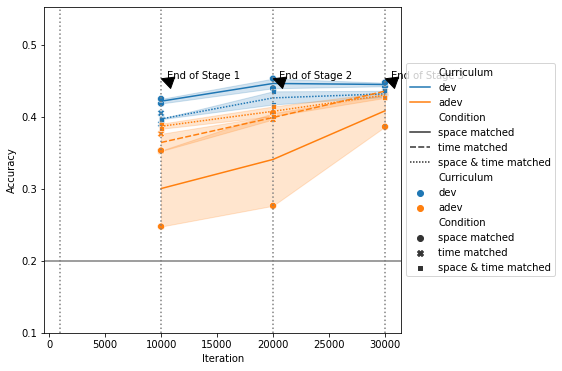

In [78]:
cdata = df_all
fig,ax = plt.subplots(1,1, figsize=(8,6), sharex=True)

x,y='Iteration','Accuracy'
plot_multistage(cdata, x,y, ax, ds_task, legend=True)

In [55]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun21/'
ds_task = 'transformation'
num_ep,iter_per_ep = 5, 2000
iter_per_stage = num_ep*iter_per_ep
df21 = proc_result_folder(emb_root, ds_task, iter_per_stage)
df21['Condition'] = df21['Condition'].map({'default':'time matched'})

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


In [56]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun26/'
ds_task = 'transformation'
num_ep,iter_per_ep = 5, 2000
iter_per_stage = num_ep*iter_per_ep
df26 = proc_result_folder(emb_root, ds_task, iter_per_stage)

  0%|                                                     | 0/4 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.60s/it]


In [57]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/jun27/'
ds_task = 'transformation'
num_ep,iter_per_ep = 5, 2000
iter_per_stage = num_ep*iter_per_ep
df27 = proc_result_folder(emb_root, ds_task, iter_per_stage)

 75%|█████████████████████████████████▊           | 3/4 [00:07<00:02,  2.38s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
  0%|                                                     | 0/4 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.48s/it]


In [58]:
condition_mapdict={'default':'space matched',
                  'notime':'space & time matched'}
df26['Condition'] = df26['Condition'].map(condition_mapdict)
df27['Condition'] = df27['Condition'].map(condition_mapdict)

In [59]:
df_all_trans = pd.concat((df21, df26, df27), ignore_index=True)

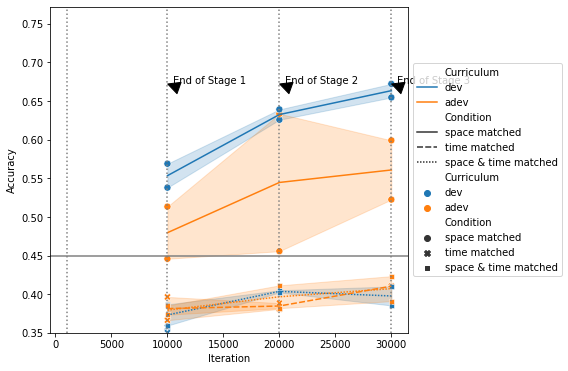

In [70]:
cdata = df_all_trans
fig,ax = plt.subplots(1,1, figsize=(8,6), sharex=True)

x,y='Iteration','Accuracy'
plot_multistage(cdata, x,y, ax, ds_task, legend=True)